In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import os
path = os.getcwd()
import math

import yfinance as yf
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import datetime as dt

거래량 보다 거래대금!

In [2]:
pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


# 1. S&P500 가격 테이블 만들기

In [3]:
ticker = '^GSPC'
start_date = date.today() - timedelta(100)
end_date = date.today()

In [4]:
end_date

datetime.date(2023, 11, 5)

In [5]:
yf_stock_data = yf.Ticker(ticker)
df_SandP500_raw = yf_stock_data.history(start=start_date, end=end_date).reset_index()

In [6]:
df_SandP500_raw.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-07-28 00:00:00-04:00,4565.750000,4590.160156,4564.009766,4582.229980,3981010000,0.0,0.0
1,2023-07-31 00:00:00-04:00,4584.819824,4594.220215,4573.140137,4588.959961,4503600000,0.0,0.0
2,2023-08-01 00:00:00-04:00,4578.830078,4584.620117,4567.529785,4576.729980,4042370000,0.0,0.0
3,2023-08-02 00:00:00-04:00,4550.930176,4550.930176,4505.750000,4513.390137,4270710000,0.0,0.0
4,2023-08-03 00:00:00-04:00,4494.270020,4519.490234,4485.540039,4501.890137,4149120000,0.0,0.0


In [7]:
def getting_stock_price_change(df, colname):
    df_new = pd.DataFrame()
    for i in df.index[1:]:
        ytd = df[df.index == i - 1]
        tdy = df[df.index == i]
        change = round(((tdy.iloc[0].Close - ytd.iloc[0].Close)/ytd.iloc[0].Close) * 100, 2) 
        tdy[f'{colname}_change'] = change
        df_new = pd.concat([df_new, tdy])
        
        
#         N1 = abs(ytd.iloc[0].High - ytd.iloc[0].Low)
#         # N2 = 전일 종가 - 당일 고가의 절대값
#         N2 = abs(ytd.iloc[0].Close - tdy.iloc[0].High)
#         # N3 = 전일 종가 - 당일 저가의 절대값
#         N3 = abs(ytd.iloc[0].Close - tdy.iloc[0].Low)
#         tdy['ATR'] = max(N1, N2, N3)
#         #print(ATR)
#         #df_new = df_new.append(tdy)
#         df_ttl = pd.concat([df_ttl, tdy])
        
#     df_ttl['ATR20'] = df_ttl['ATR'].rolling(20).mean()
#     #df_ttl = df_ttl.dropna(axis=0)
#     df_ttl.index = df_ttl.Date
#     df_ttl = df_ttl.drop(columns = ['Date'])
    df_new.index = df_new['Date']
    #print(df_new.head())
    #new_price_column = colname
    #print(new_price_column)
    df_new = df_new.rename(columns={'Close' : colname})
    return df_new[[colname, f'{colname}_change']]

In [8]:
df_all = getting_stock_price_change(df_SandP500_raw, 'SandP500')

In [9]:
df_all.tail()

,SandP500,SandP500_change
Date,,
2023-10-30 00:00:00-04:00,4166.819824,1.20
2023-10-31 00:00:00-04:00,4193.799805,0.65
2023-11-01 00:00:00-04:00,4237.859863,1.05
2023-11-02 00:00:00-04:00,4317.779785,1.89
2023-11-03 00:00:00-04:00,4358.339844,0.94


# 2. S&P500 Sector 별 가격 변화 추적하기

1. 에너지 (Energy): Energy Select Sector SPDR Fund (XLE)
2. 소재 (Materials): Materials Select Sector SPDR Fund (XLB)
3. 산업재 (Industrials): Industrial Select Sector SPDR Fund (XLI)
4. 소비자 디스크레션러리 (Consumer Discretionary): Consumer Discretionary Select Sector SPDR Fund (XLY)
5. 소비자 스테이플스 (Consumer Staples): Consumer Staples Select Sector SPDR Fund (XLP)
6. 헬스케어 (Health Care): Health Care Select Sector SPDR Fund (XLV)
7. 금융 (Financials): Financial Select Sector SPDR Fund (XLF)
8. 정보기술 (Information Technology): Technology Select Sector SPDR Fund (XLK)
9. 통신 서비스 (Communication Services): Communication Services Select Sector SPDR Fund (XLC)
10. 유틸리티 (Utilities): Utilities Select Sector SPDR Fund (XLU)
11. 부동산 (Real Estate): Real Estate Select Sector SPDR Fund (XLRE)

In [10]:
Sectors = {'Energy': 'XLE',
           'Materials': 'XLB',
           'Industrials': 'XLI',
           'Consumer_Discretionary': 'XLY',
           'Consumer_Staples': 'XLP',
           'Health_Care': 'XLV',
           'Financials': 'XLF',
           'Information_Technology': 'XLK',
           'Conmmuication_Services': 'XLC',
           'Utilities': 'XLU',
           'Real_Estate': 'XLRE'}

In [11]:
for i in Sectors:
    print(i, Sectors[i])
#    df_sector_raw = pd.DateFrame()
    sector_data = yf.Ticker(Sectors[i])
    df_sector = sector_data.history(start=start_date, end=end_date).reset_index()
    df_sector = getting_stock_price_change(df_sector, i)
    df_all = df_all.join(df_sector, how='inner')
    

Energy XLE
Materials XLB
Industrials XLI
Consumer_Discretionary XLY
Consumer_Staples XLP
Health_Care XLV
Financials XLF
Information_Technology XLK
Conmmuication_Services XLC
Utilities XLU
Real_Estate XLRE


In [12]:
df_all.tail()

,SandP500,SandP500_change,Energy,Energy_change,Materials,Materials_change,Industrials,Industrials_change,Consumer_Discretionary,Consumer_Discretionary_change,...,Financials,Financials_change,Information_Technology,Information_Technology_change,Conmmuication_Services,Conmmuication_Services_change,Utilities,Utilities_change,Real_Estate,Real_Estate_change
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-30 00:00:00-04:00,4166.819824,1.20,84.910004,0.33,75.720001,1.03,97.639999,1.24,150.960007,0.92,...,32.009998,1.78,162.850006,1.07,64.389999,2.06,59.180000,0.77,32.450001,0.31
2023-10-31 00:00:00-04:00,4193.799805,0.65,85.190002,0.33,76.059998,0.45,98.360001,0.74,152.100006,0.76,...,32.360001,1.09,164.009995,0.71,64.720001,0.51,59.689999,0.86,33.099998,2.00
2023-11-01 00:00:00-04:00,4237.859863,1.05,84.989998,-0.23,76.099998,0.05,98.680000,0.33,153.979996,1.24,...,32.570000,0.65,167.179993,1.93,65.669998,1.47,60.369999,1.14,33.270000,0.51
2023-11-02 00:00:00-04:00,4317.779785,1.89,87.559998,3.02,77.570000,1.93,100.709999,2.06,158.000000,2.61,...,33.340000,2.36,170.009995,1.69,66.540001,1.32,61.500000,1.87,34.299999,3.10
2023-11-03 00:00:00-04:00,4358.339844,0.94,86.680000,-1.01,78.790001,1.57,101.599998,0.88,160.220001,1.41,...,33.779999,1.32,171.759995,1.03,67.559998,1.53,61.860001,0.59,35.110001,2.36


# 3. 기간 별 시장 선도 섹터 찾기

In [13]:
df_all.columns

Index(['SandP500', 'SandP500_change', 'Energy', 'Energy_change', 'Materials',
       'Materials_change', 'Industrials', 'Industrials_change',
       'Consumer_Discretionary', 'Consumer_Discretionary_change',
       'Consumer_Staples', 'Consumer_Staples_change', 'Health_Care',
       'Health_Care_change', 'Financials', 'Financials_change',
       'Information_Technology', 'Information_Technology_change',
       'Conmmuication_Services', 'Conmmuication_Services_change', 'Utilities',
       'Utilities_change', 'Real_Estate', 'Real_Estate_change'],
      dtype='object')

In [14]:
df_all_change = df_all.filter(regex='change')
df_all_price = df_all.drop(columns=df_all_change.columns)

In [15]:
df_all_change.tail()

,SandP500_change,Energy_change,Materials_change,Industrials_change,Consumer_Discretionary_change,Consumer_Staples_change,Health_Care_change,Financials_change,Information_Technology_change,Conmmuication_Services_change,Utilities_change,Real_Estate_change
Date,,,,,,,,,,,,
2023-10-30 00:00:00-04:00,1.20,0.33,1.03,1.24,0.92,1.56,0.56,1.78,1.07,2.06,0.77,0.31
2023-10-31 00:00:00-04:00,0.65,0.33,0.45,0.74,0.76,0.35,0.57,1.09,0.71,0.51,0.86,2.00
2023-11-01 00:00:00-04:00,1.05,-0.23,0.05,0.33,1.24,-0.10,0.21,0.65,1.93,1.47,1.14,0.51
2023-11-02 00:00:00-04:00,1.89,3.02,1.93,2.06,2.61,1.30,1.59,2.36,1.69,1.32,1.87,3.10
2023-11-03 00:00:00-04:00,0.94,-1.01,1.57,0.88,1.41,0.12,0.50,1.32,1.03,1.53,0.59,2.36


In [50]:
def finding_leading_sector(df_change, Sectors, start, end):
    days = end-start
    if start == 0:
        df = df_change.tail(end)
    else:
        df = df_change.iloc[-end:-start]
    dfs = []
    column_winning = f'winning rate between -{start} and -{end}'
    for i, sector in enumerate(Sectors):
        #print(sector)
        colname = f'{sector}_change'
        diff = df[colname] - df['SandP500_change']
        winning = (diff > 0).sum()
        winning_rate = round((winning / days)*100, 2)
        #print(winning_rate)
        new_row = pd.DataFrame({'Sector':sector, column_winning: winning_rate}, index=[i])
#        df_output = pd.concat([df_output, new_row], ignore_index=True)
        dfs.append(new_row)
    #print(dfs)
    return pd.concat(dfs)

In [51]:
#df_10 = finding_leading_sector(df_all_change, Sectors, 10)
df_20 = finding_leading_sector(df_all_change, Sectors, 0, 20)
df_40_20 = finding_leading_sector(df_all_change, Sectors, 20, 40)
df_60_40 = finding_leading_sector(df_all_change, Sectors, 40, 60)


In [52]:
dfs = [df_60_40, df_40_20, df_20]

In [53]:
from functools import reduce

In [54]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Sector'],
                                            how='inner'), dfs)

In [55]:
df_merged.index = df_merged.Sector

In [56]:
df_merged = df_merged.drop(columns = ['Sector'])

In [57]:
import matplotlib.pyplot as plt 
#plt.style.use('ggplot')
import seaborn

seaborn.set()

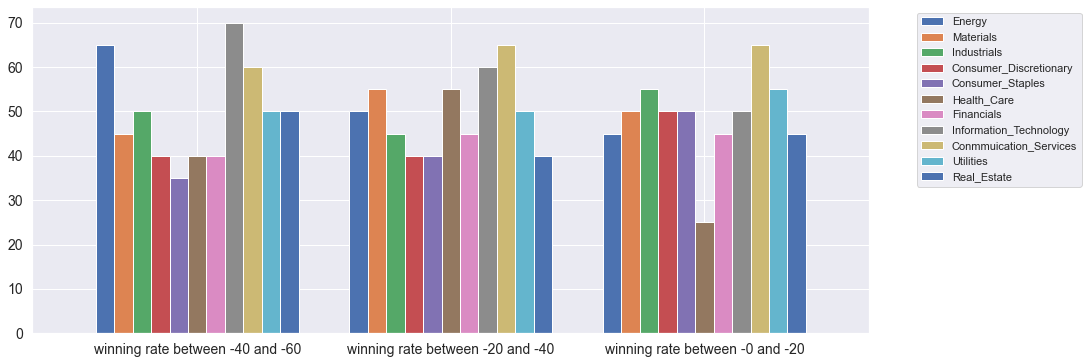

In [58]:
ax = df_merged.T.plot(kind="bar", width=0.8)
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(15, 6)
# Change the axes labels
# ax.set_xlabel("Years")
# ax.set_ylabel("Average Page Views")

# Use this to show the plot in a new window
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=0, fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylabel('%')
plt.show()

# 4. 섹터내 주도주 찾기

In [ ]:
Sectors = {'XLE':['XOM', 'CVX'], #Exxon Mobile, Chevron
           'XLB':[],
           'XLI':[],
           'XLY':[],
           'XLP':[],
           'XLV':[],
           'XLF':[],
           'XLK':[],
           'XLC':[],
           'XLU':[],
           'XLRE':[]}